![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [2]:
import warnings
warnings.filterwarnings('ignore')
decision = 2 #1 Correr normalmente, 2 cargar info

In [1]:
# Importación librerías
from sentence_transformers import SentenceTransformer
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import pickle
import joblib
from sklearn.metrics import confusion_matrix

#from keras.preprocessing import sequence
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import nltk
import math

#nltk.download('omw')
from keras.callbacks import EarlyStopping


from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

from keras.activations import relu, swish, sigmoid
from livelossplot import PlotLossesKeras
#from sentence_transformers import SentenceTransformer

from flask import Flask
from flask_restx import Api, Resource, fields

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

Prueba finaaaaal final no va mas

In [10]:
# Visualización datos de entrenamiento
prueba = dataTraining['plot'][900]
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [73]:
model_all_Mini = SentenceTransformer('all-MiniLM-L6-v2')

sentences = dataTraining['plot'].tolist()
embeddings = model_all_Mini.encode(sentences,show_progress_bar=True)

joblib.dump(model_all_Mini,'AllMiniModel.pkl')
embeddings.shape

Batches:   0%|          | 0/247 [00:00<?, ?it/s]

(7895, 384)

In [74]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(embeddings, y_genres, test_size=0.33, random_state=42)

In [6]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [7]:
#Pasar palabras a minusculas
def minusculizar(df):
    df2 = df.copy()
    df2['title'] = df2['title'].apply(lambda x : x.lower())
    df2['plot'] = df2['plot'].apply(lambda x : x.lower())
    return df2

dataTraining_min  = minusculizar(dataTraining)
dataTraining_min

,year,title,plot,genres,rating
3107,2003,most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,how to be a serial killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,a woman's face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,executive suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,narrow margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6
...,...,...,...,...,...
8417,2010,our family wedding,""" our marriage , their wedding . "" it ' s l...","['Comedy', 'Romance']",4.9
1592,1984,conan the destroyer,"the wandering barbarian , conan , alongside ...","['Action', 'Adventure', 'Fantasy']",5.8
1723,1955,kismet,"like a tale spun by scheherazade , kismet fol...","['Adventure', 'Musical', 'Fantasy', 'Comedy', ...",6.4
7605,1982,the secret of nimh,"mrs . brisby , a widowed mouse , lives in a...","['Animation', 'Adventure', 'Drama', 'Family', ...",7.6


Plots

In [8]:
Listadeplots = dataTraining_min['plot'].tolist()
lista_palabras=[]
for i in Listadeplots:
    lista_palabras.extend(i.split())
palabras_unicas_plot = list(set(lista_palabras))

stopwords_english = nltk.corpus.stopwords.words('english')

lista_palabras_completa_filtrada = [palabra for palabra in lista_palabras if palabra.lower() not in stopwords_english]
lista_filtrada_plot = set(lista_palabras_completa_filtrada)

len(palabras_unicas_plot),len(lista_filtrada_plot)

(38734, 38584)

Creacion del diccionario de lematización

In [9]:
# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Mapear las etiquetas POS de NLTK a las etiquetas POS de WordNet
tag_map = {
    'N': nltk.corpus.wordnet.NOUN,
    'V': nltk.corpus.wordnet.VERB,
    'R': nltk.corpus.wordnet.ADV,
    'J': nltk.corpus.wordnet.ADJ
}

# Lematizar la lista de palabras
lista_lematizada = []
for palabra in lista_filtrada_plot:
    # Obtener la etiqueta POS de cada palabra
    pos_tag = nltk.pos_tag([palabra])[0][1][0].upper()
    # Mapear la etiqueta POS a las etiquetas POS de WordNet
    pos_tag = tag_map.get(pos_tag, nltk.corpus.wordnet.NOUN)
    
    # Lematizar la palabra
    lema = lemmatizer.lemmatize(palabra, pos=pos_tag)
    lista_lematizada.append(lema)

# Imprimir la lista de palabras lematizada
print(lista_lematizada)

diccionario_original_a_lemas = {clave: valor for clave, valor in zip(lista_filtrada_plot, lista_lematizada)}


lista_unicos_lematizada = list(set(lista_lematizada))
len(lista_unicos_lematizada)

['voltage', 'bear', 'dairy', 'roadie', 'finance', 'picklers', 'tahiti', 'cottrell', 'guacamole', 'unleashed', 'pygmalion', 'anthropologist', 'pit', 'filter', 'dulaine', 'ryden', 'vilos', 'chablis', 'fighter', 'favourable', 'prescription', 'bingley', 'rick', 'confide', 'anoke', 'spends', 'verity', 'crystal', 'atoll', 'thriller', 'banditos', 'melange', 'emptiness', 'humanely', 'jockey', 'obsession', 'crew', 'brite', 'bluffing', 'hayne', 'jered', 'biaggio', 'lippe', 'extracurricular', 'clemens', 'simulation', 'pakistani', 'graffiti', 'core', 'surgeon', 'suzy', 'intention', 'ohio', 'stefano', 'wickedly', 'oz', 'blare', 'burgundy', 'zara', 'verver', 'wienberg', 'stall', 'graveyard', 'cringes', 'liotta', 'hotly', 'attract', 'heft', 'hospitalsmand', 'matchmaker', 'seduce', 'pamper', 'olsen', 'bartender', 'board', 'mchugh', 'kraken', 'truckin', 'reemerges', 'witchcraft', 'tactfully', 'censorship', 'prim', 'court', 'rourke', 'fulfills', 'douses', 'dearly', 'cullen', 'mamie', 'tavington', 'quo',

31371

Palabras lematizadas más comunes

In [10]:
df_Listado_completo_filtrado_no_stopwords = pd.DataFrame(lista_palabras_completa_filtrada,columns=['words'])
df_Listado_completo_filtrado_no_stopwords['Lematized'] = df_Listado_completo_filtrado_no_stopwords['words'].apply(lambda x : diccionario_original_a_lemas[x])
df_Listado_completo_filtrado_no_stopwords['Count'] = 1
Repeticiones_por_lematized = df_Listado_completo_filtrado_no_stopwords[['Lematized','Count']].groupby('Lematized').sum().reset_index().sort_values('Count',ascending=False)
filtro = Repeticiones_por_lematized['Lematized'].apply(lambda x: len(x) > 1)
resultados_filtrados = Repeticiones_por_lematized[filtro].reset_index(drop=True)
Total_palabras = resultados_filtrados['Count'].sum()
resultados_filtrados['Part'] = resultados_filtrados['Count'].apply(lambda x: x/Total_palabras)
resultados_filtrados['Acumulado'] = resultados_filtrados['Part'].cumsum()
Porcentaje = 1.01
pareto = resultados_filtrados[resultados_filtrados['Acumulado']<=Porcentaje].shape
print('El '+str(Porcentaje*100) + '% de las palabras se encuentra en las primeras ' + str(pareto[0]))

Palabras_Para_Clasificar_Lematizadas = resultados_filtrados[resultados_filtrados['Acumulado']<=Porcentaje]['Lematized'].tolist()

vocabulario_lematizado = {palabra: indice for indice, palabra in enumerate(Palabras_Para_Clasificar_Lematizadas)}

resultados_filtrados.head(10)

El 101.0% de las palabras se encuentra en las primeras 31330


,Lematized,Count,Part,Acumulado
0,life,3640,0.006784,0.006784
1,one,3068,0.005718,0.012502
2,get,3068,0.005718,0.018219
3,find,2875,0.005358,0.023577
4,go,2405,0.004482,0.028059
5,new,2271,0.004232,0.032292
6,take,2240,0.004175,0.036466
7,friend,2190,0.004081,0.040548
8,year,2085,0.003886,0.044434
9,make,2057,0.003834,0.048267


Variable de interes

In [11]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

Lematizar texto original y eliminar stopwords

In [12]:
def lematizar_texto(texto, diccionario):
    palabras = texto.split()  # Dividir el texto en palabras
    palabras_lematizadas = [diccionario.get(palabra, palabra) for palabra in palabras]  # Obtener las palabras lematizadas del diccionario
    palabras_filtradas = [palabra for palabra in palabras_lematizadas if palabra.lower() not in stopwords_english]  # Filtrar las stopwords
    texto_lematizado = ' '.join(palabras_filtradas)  # Unir las palabras lematizadas en un nuevo texto
    return texto_lematizado

dataTraining_min['plot_lematized'] = dataTraining_min['plot'].apply(lambda x: lematizar_texto(x,diccionario_original_a_lemas))
dataTraining_min.head()


,year,title,plot,genres,rating,plot_lematized
3107,2003,most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,story single father take eight year - old son ...
900,2008,how to be a serial killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,serial killer decides teach secret satisfy car...
6724,1941,a woman's face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,"sweden , female blackmailer disfigure facial s..."
4704,1954,executive suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,"friday afternoon new york , president tredway ..."
2582,1990,narrow margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,"los angeles , editor publishing house carol hu..."


Conteo de palabras por cada genero

In [13]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

if decision == 1:
    dataTraining_plot = dataTraining_min['plot_lematized'].reset_index(drop=True)

    df_y_genres = pd.DataFrame(y_genres,columns=cols)
    df_a_evaluar = pd.concat((dataTraining_plot,df_y_genres),axis=1)

    participaciones = pd.DataFrame(index=vocabulario_lematizado, columns=df_a_evaluar.columns[1:])
    participaciones
    contador=1
    actual = 0.05
    for palabra in vocabulario_lematizado:
        # Calcular la participación de la palabra en cada género
        completado= contador/len(vocabulario_lematizado)
        if completado > actual:
            print('% Completado: ' + str(round(actual*100,0)))
            actual += 0.05

        for genero in df_a_evaluar.columns[1:]:
            total_words = df_a_evaluar[df_a_evaluar[genero] == 1]['plot_lematized'].apply(len).sum()
            # Calcular la frecuencia de aparición de la palabra en el género
            freq = df_a_evaluar[df_a_evaluar[genero] == 1]['plot_lematized'].str.count(palabra).sum()
            # Almacenar la participación en el DataFrame
            participaciones.at[palabra, genero] = freq
        contador +=1 

    participaciones.head()

    joblib.dump(participaciones,'Participaciones2.pkl', compress=3)
    joblib.dump(df_a_evaluar,'df_a_evaluar.pkl', compress=3)
else:
    participaciones = joblib.load('Participaciones 100% de las palabras.pkl')
    df_a_evaluar = joblib.load('df_a_evaluar.pkl')
    print('se cargaron particiones y df evaluar desde los datos guardados')

se cargaron particiones y df evaluar desde los datos guardados


In [105]:

from sklearn.feature_extraction.text import TfidfVectorizer

X_trop = df_a_evaluar['plot_lematized']
y_Trop = df_a_evaluar.iloc[:,1:]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_trop, y_Trop, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_2).todense()
X_test_tfidf = vectorizer.transform(X_test_2).todense()
X_test_tfidf.shape

(1579, 28073)

Conteo ponderado

In [14]:
suma_filas = participaciones.sum(axis=1)
participaciones_por_fila = participaciones.div(suma_filas, axis=0)
participaciones_por_fila.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
life,0.039037,0.035613,0.009197,0.023481,0.152725,0.055865,0.016926,0.247627,0.027395,0.034439,...,0.010664,0.028079,0.000391,0.126113,0.024264,0.001272,0.012621,0.072987,0.013404,0.00724
one,0.066641,0.050104,0.008896,0.014846,0.131754,0.075483,0.010479,0.187698,0.025925,0.031001,...,0.012171,0.042517,0.000164,0.08891,0.032256,0.00262,0.011243,0.10512,0.017465,0.011898
get,0.063739,0.046315,0.010045,0.007912,0.17886,0.076007,0.005512,0.177882,0.034314,0.028536,...,0.013868,0.031025,0.0,0.109965,0.025336,0.002845,0.012179,0.09183,0.014046,0.009956
find,0.062366,0.057486,0.014639,0.009284,0.131516,0.067841,0.003809,0.163413,0.03761,0.040109,...,0.012378,0.051892,0.0,0.084742,0.041895,0.001904,0.007498,0.107593,0.012973,0.00976
go,0.07375,0.059133,0.011778,0.012563,0.14309,0.070669,0.009181,0.172203,0.035335,0.039865,...,0.011718,0.032737,0.000302,0.084803,0.034972,0.002718,0.012745,0.097065,0.012986,0.012443


In [89]:
participaciones_por_fila['p_Drama'].sort_values(ascending=False)

peekay          1.0
twickenham      1.0
octogenarian    1.0
odone           1.0
odones          1.0
               ... 
automate        0.0
cliffhanging    0.0
us$             NaN
u$              NaN
a$$             NaN
Name: p_Drama, Length: 31330, dtype: object

Revisión de balanceo de clases

In [15]:
lista_repetidos=[]
for i in df_a_evaluar.columns[1:]:
    lista_repetidos.append(df_a_evaluar[i].sum())
Balance_DF = pd.DataFrame(zip(df_a_evaluar.columns[1:],lista_repetidos),columns=['genero','Cant']).sort_values(by='Cant',ascending=False)
Balance_DF

,genero,Cant
7,p_Drama,3965
4,p_Comedy,3046
21,p_Thriller,2024
17,p_Romance,1892
5,p_Crime,1447
0,p_Action,1303
1,p_Adventure,1024
12,p_Horror,954
15,p_Mystery,759
18,p_Sci-Fi,723


Calculo de tf_IDF

In [16]:
joblib.dump(participaciones,'Participaciones.pkl', compress=3)

tf_idf_values = participaciones * 0
# Número total de géneros
total_genres = len(df_a_evaluar.columns) - 1

# Calcular la frecuencia de aparición de cada palabra en cada género
for genre in df_a_evaluar.columns[1:]:
    total_words = df_a_evaluar[df_a_evaluar[genre] == 1]['plot_lematized'].apply(len).sum()
    for word in participaciones.index:
        freq = participaciones.loc[word, genre]
        tf = freq / total_words
        num_genres_with_word = participaciones.loc[word].gt(0).sum()  # Número de géneros en los que aparece la palabra
        idf = math.log(total_genres / num_genres_with_word)
        tf_idf = tf * idf        
        tf_idf_values.loc[word, genre] = tf_idf

Valores_Tf_Idf_Mas_Altos = tf_idf_values.sum(axis=1).sort_values(ascending=False)
Valores_Tf_Idf_Mas_Altos.head(10)

showrunners    0.003565
swartz         0.002311
rd             0.001688
wi             0.001419
ant            0.001321
pi             0.001206
google         0.001050
ack            0.001044
pooh           0.000944
get            0.000942
dtype: float64

Analisis por métrica de TF_IDF por palabras

In [17]:
TF_IDF_Mas_Alto_Por_Genero = {}
Listado_palabras_unicas_por_Tf_Idf = []
Nuevo_vocabulario_por_Tf_Idf  = {}
max_palabras = 600
for i in tf_idf_values.columns:
    Words_selected = tf_idf_values[i].sort_values(ascending=False).reset_index()['index'].tolist()[:max_palabras]
    TF_IDF_Mas_Alto_Por_Genero[i]= Words_selected
    Listado_palabras_unicas_por_Tf_Idf.extend(Words_selected)
Listado_palabras_unicas_por_Tf_Idf = list(set(Listado_palabras_unicas_por_Tf_Idf))
Nuevo_vocabulario_por_Tf_Idf = {palabra: indice for indice, palabra in enumerate(Listado_palabras_unicas_por_Tf_Idf)}


print(len(TF_IDF_Mas_Alto_Por_Genero),len(Listado_palabras_unicas_por_Tf_Idf),len(Nuevo_vocabulario_por_Tf_Idf))
#Nuevo_vocabulario_por_Tf_Idf

24 7566 7566


Vectorización

In [18]:
Opciones_para_Vocabularios = {1:vocabulario_lematizado,2:Nuevo_vocabulario_por_Tf_Idf}
vectorizer = CountVectorizer(vocabulary=Opciones_para_Vocabularios[2]) #Opcion 1
xplot_vectorizer = vectorizer.fit_transform(dataTraining_min['plot_lematized'])
features = vectorizer.get_feature_names_out()
prueba = dataTraining_min['plot_lematized'].tolist()[2].split()
print(xplot_vectorizer.shape)
xplot_vectorizer

(7895, 7566)


<7895x7566 sparse matrix of type '<class 'numpy.int64'>'
	with 148669 stored elements in Compressed Sparse Row format>

In [19]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(xplot_vectorizer, y_genres, test_size=0.33, random_state=42)

In [121]:
# Definición y entrenamiento
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1))
clf.fit(X_train, y_train_genres)

KeyboardInterrupt: 

In [72]:
# Predicción del modelo de clasificación
#X_train_2, X_test_2, y_train_2, y_test_2

y_pred_genres = clf.predict_proba(X_test)

auc_scores = roc_auc_score(y_test_genres, y_pred_genres, average=None)
AUC_TOTAL=roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print('AUC_TOTAL: ' +str(AUC_TOTAL))

Para_df={}
for class_idx, auc_score in enumerate(auc_scores):
    Para_df[cols[class_idx]]=auc_score
DF_AUC_Generos = pd.DataFrame(Para_df.values(),columns=['AUC'],index=Para_df.keys())
DF_AUC_Generos=DF_AUC_Generos.sort_values(by='AUC')


y_test_genres_df = pd.DataFrame(y_test_genres,columns=cols)
y_pred_genres_df = pd.DataFrame(y_pred_genres,columns=cols)
confusion_matrices = {}

threshold = 0.5  # Umbral


for class_label in cols:
    y_true = y_test_genres_df[class_label]
    y_pred = y_pred_genres_df[class_label] 
    y_pred_binary = np.where(y_pred > threshold, 1, 0)

    cm = confusion_matrix(y_true, y_pred_binary)
    confusion_matrices[class_label] = cm
DF_AUC_Generos['Matriz Conf.'] = [confusion_matrices.get(genre) for genre in DF_AUC_Generos.index]


Estimador_Vs_AUCS = [clf,AUC_TOTAL,DF_AUC_Generos]



joblib.dump(Estimador_Vs_AUCS,'Lista_2_params_por_defecto_25-05-23 AUC' + str(AUC_TOTAL)+'.pkl', compress=3)


DF_AUC_Generos

AUC_TOTAL: 0.8250049612009377


,AUC,Matriz Conf.
p_Drama,0.707760,"[[823, 500], [408, 875]]"
p_Biography,0.725916,"[[2472, 4], [124, 6]]"
p_Comedy,0.756307,"[[1355, 223], [553, 475]]"
p_History,0.766654,"[[2522, 4], [76, 4]]"
p_Film-Noir,0.777567,"[[2545, 4], [54, 3]]"
p_Romance,0.778069,"[[1838, 135], [392, 241]]"
p_Musical,0.780056,"[[2490, 19], [88, 9]]"
p_Thriller,0.787806,"[[1799, 147], [420, 240]]"
p_Fantasy,0.789327,"[[2334, 29], [197, 46]]"
p_Short,0.794591,"[[2574, 2], [28, 2]]"


prueba 1 redes neuronales

In [ ]:
#keras.backend.clear_session()
#model = Sequential()
#model.add(Dense(342, input_shape=(X_train.shape[1],),activation=sigmoid)) 
#model.add(Dropout(0.10769379659079174))
#model.add(Dense(64,activation=sigmoid))
#model.add(Dropout(0.0020769379659079174))

#model.add(Dense(24, activation=sigmoid))

In [59]:
keras.backend.clear_session()
model = Sequential()
model.add(Dense(342, input_shape=(X_train.shape[1],),activation=sigmoid)) 
model.add(Dropout(0.12))
model.add(Dense(64,activation=sigmoid))

model.add(Dense(24, activation=sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 342)               131670    
                                                                 
 dropout (Dropout)           (None, 342)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                21952     
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
Total params: 155,182
Trainable params: 155,182
Non-trainable params: 0
_________________________________________________________________


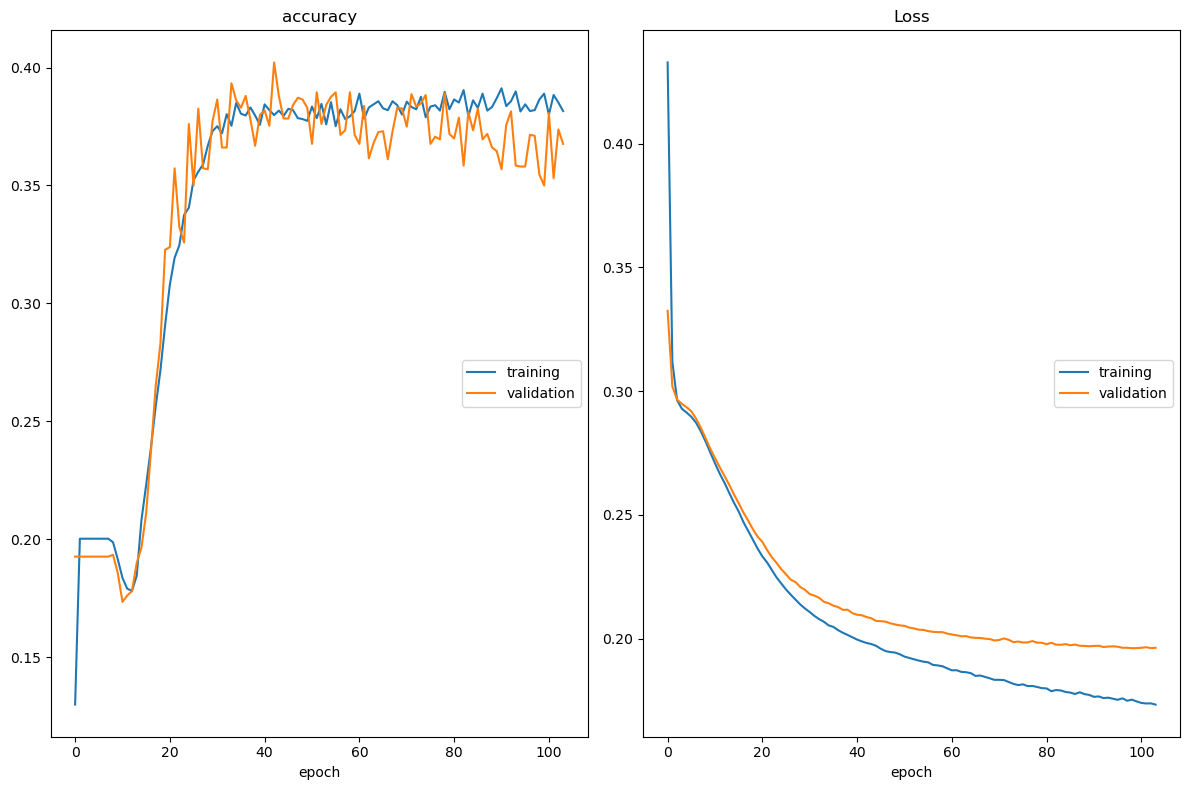

accuracy
	training         	 (min:    0.130, max:    0.391, cur:    0.382)
	validation       	 (min:    0.173, max:    0.402, cur:    0.368)
Loss
	training         	 (min:    0.173, max:    0.433, cur:    0.173)
	validation       	 (min:    0.196, max:    0.332, cur:    0.196)
42/42 [==============================] - 0s 11ms/step - loss: 0.1733 - accuracy: 0.3815 - val_loss: 0.1963 - val_accuracy: 0.3676
Epoch 104: early stopping


In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_genres, validation_data=(X_test, y_test_genres),
          batch_size=128, epochs=125, verbose=1,
          callbacks=[early_stopping,PlotLossesKeras()])
model.save_weights('pesos_modelo_X.h5')

In [61]:
# Cálculo del AUC de cada clase

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']


y_pred_genres=model.predict(X_test)
auc_scores = roc_auc_score(y_test_genres, y_pred_genres, average=None)

AUC_TOTAL=roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print('AUC_TOTAL: ' +str(AUC_TOTAL))
# Impresión del AUC de cada clase

Para_df={}
for class_idx, auc_score in enumerate(auc_scores):
    Para_df[cols[class_idx]]=auc_score
DF_AUC_Generos = pd.DataFrame(Para_df.values(),columns=['AUC'],index=Para_df.keys())
DF_AUC_Generos=DF_AUC_Generos.sort_values(by='AUC')


y_test_genres_df = pd.DataFrame(y_test_genres,columns=cols)
y_pred_genres_df = pd.DataFrame(y_pred_genres,columns=cols)
confusion_matrices = {}

threshold = 0.5  # Umbral


for class_label in cols:
    y_true = y_test_genres_df[class_label]
    y_pred = y_pred_genres_df[class_label] 
    y_pred_binary = np.where(y_pred > threshold, 1, 0)

    cm = confusion_matrix(y_true, y_pred_binary)
    confusion_matrices[class_label] = cm
DF_AUC_Generos['Matriz Conf.'] = [confusion_matrices.get(genre) for genre in DF_AUC_Generos.index]

DF_AUC_Generos

82/82 [==============================] - 0s 1ms/step
AUC_TOTAL: 0.8888012219722702


,AUC,Matriz Conf.
p_Drama,0.776449,"[[874, 449], [345, 938]]"
p_Short,0.786711,"[[2576, 0], [30, 0]]"
p_Thriller,0.827921,"[[1735, 211], [313, 347]]"
p_Romance,0.831169,"[[1834, 139], [350, 283]]"
p_Comedy,0.835307,"[[1312, 266], [340, 688]]"
p_Film-Noir,0.847680,"[[2549, 0], [57, 0]]"
p_Mystery,0.854945,"[[2323, 41], [186, 56]]"
p_Musical,0.862018,"[[2504, 5], [87, 10]]"
p_Fantasy,0.865862,"[[2311, 52], [163, 80]]"
p_News,0.872455,"[[2603, 0], [3, 0]]"


Calibración

In [ ]:
# Importación librerías
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

Random Search

In [85]:
# Definición de función que crea una red neuronal a partir de diferentes parámetros (nn_model_params)
# En esta función se consideran 7 parámetos a calibrar, sin embargo se pueden agregar o quitar tantos como lo consideren pertinente
def nn_model_params(optimizer ,
                    neurons_1,
                    dropout_1,
                    neurons_2,
                    dropout_2,
                    batch_size,
                    epochs,
                    activation_1,
                    activation_2,
                    activation_3,
                    patience,
                    loss):
    
    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()
    
    # Definición de las capas de la red con el número de neuronas y la función de activación definidos en la función nn_model_params
    model.add(Dense(neurons_1, input_shape=(X_train.shape[1],), activation=activation_1))
    model.add(Dropout(dropout_1))
    model.add(Dense(neurons_2, activation=activation_2))
    model.add(Dropout(dropout_2))

    model.add(Dense(y_train_genres.shape[1], activation=activation_3))

    # Definición de función de perdida con parámetros definidos en la función nn_model_params
    model.compile(optimizer = optimizer, loss=loss)
    
    # Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
    early_stopping = EarlyStopping(monitor="val_loss", patience = patience)

    # Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
    model.fit(X_train, y_train_genres,
              validation_data = (X_test, y_test_genres),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True
              )
     
    return model

In [86]:
# Definición de parámetros y sus valores sobre los que se va a calibrar
nn_params = {
    'optimizer': ['adam'],
    'activation_1': ['sigmoid','softmax','swish'],
    'activation_2': ['sigmoid','softmax','swish'],
    'activation_3': ['sigmoid','softmax','swish'],
    'batch_size': [64,128,680],
    'neurons_1':[64,128,256,582,689],
    'dropout_1':[0.05,0.1,0.3,0.5],
    'neurons_2':[32,64,112,232],
    'dropout_2':[0.05,0.1,0.25,0.4],
    'epochs':[110,150],
    'patience':[8,12],
    'loss':['binary_crossentropy']
}

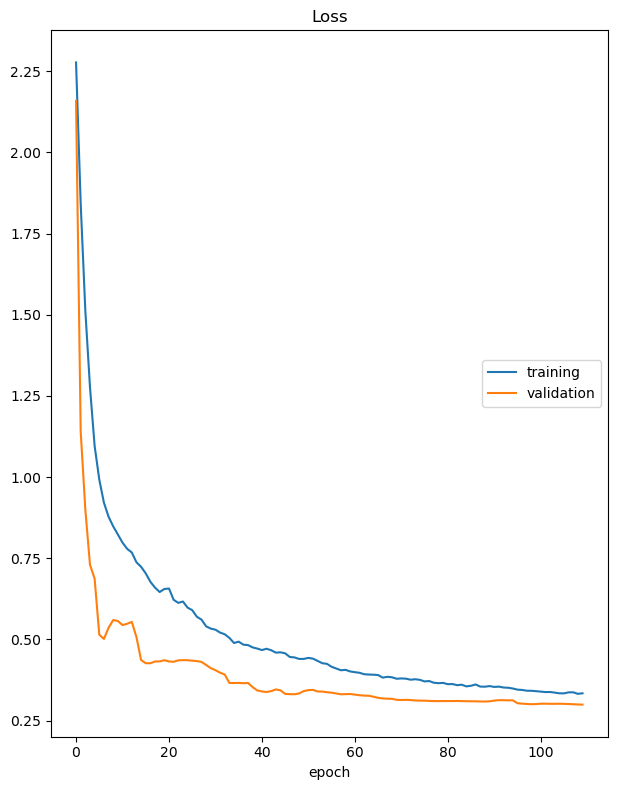

Loss
	training         	 (min:    0.332, max:    2.277, cur:    0.334)
	validation       	 (min:    0.299, max:    2.159, cur:    0.299)
8/8 [==============================] - 0s 44ms/step - loss: 0.3339 - val_loss: 0.2990
Los mejores parametros segun Randomnized Search: {'patience': 12, 'optimizer': 'adam', 'neurons_2': 64, 'neurons_1': 689, 'loss': 'binary_crossentropy', 'epochs': 110, 'dropout_2': 0.4, 'dropout_1': 0.05, 'batch_size': 680, 'activation_3': 'swish', 'activation_2': 'sigmoid', 'activation_1': 'swish'}


['Mejores_Parametros_Calibrados.pkl']

In [87]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn en la función nn_model_params
nn_model = KerasClassifier(build_fn=nn_model_params, verbose=0)

# Definición método GridSearch para la calibración de parámetros definidos en nn_params
rs = RandomizedSearchCV(nn_model, param_distributions=nn_params, n_iter=5, cv=3)
rs.fit(X_train, y_train_genres)

print('Los mejores parametros segun Randomnized Search:', rs.best_params_)
joblib.dump(rs.best_params_,'Mejores_Parametros_Calibrados.pkl', compress=3)

In [88]:
rs.best_params_

{'patience': 12,
 'optimizer': 'adam',
 'neurons_2': 64,
 'neurons_1': 689,
 'loss': 'binary_crossentropy',
 'epochs': 110,
 'dropout_2': 0.4,
 'dropout_1': 0.05,
 'batch_size': 680,
 'activation_3': 'swish',
 'activation_2': 'sigmoid',
 'activation_1': 'swish'}

Modelo calibrado

In [99]:
keras.backend.clear_session()
model = Sequential()
model.add(Dense(689, input_shape=(X_train.shape[1],),activation='swish')) 
model.add(Dropout(0.05))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.4))

model.add(Dense(24, activation='sigmoid'))
model.summary()
model.load_weights('Api_pesos_modelo_calibrado.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 689)               265265    
                                                                 
 dropout (Dropout)           (None, 689)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               88320     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 356,681
Trainable params: 356,681
Non-trainable params: 0
_________________________________________________________________


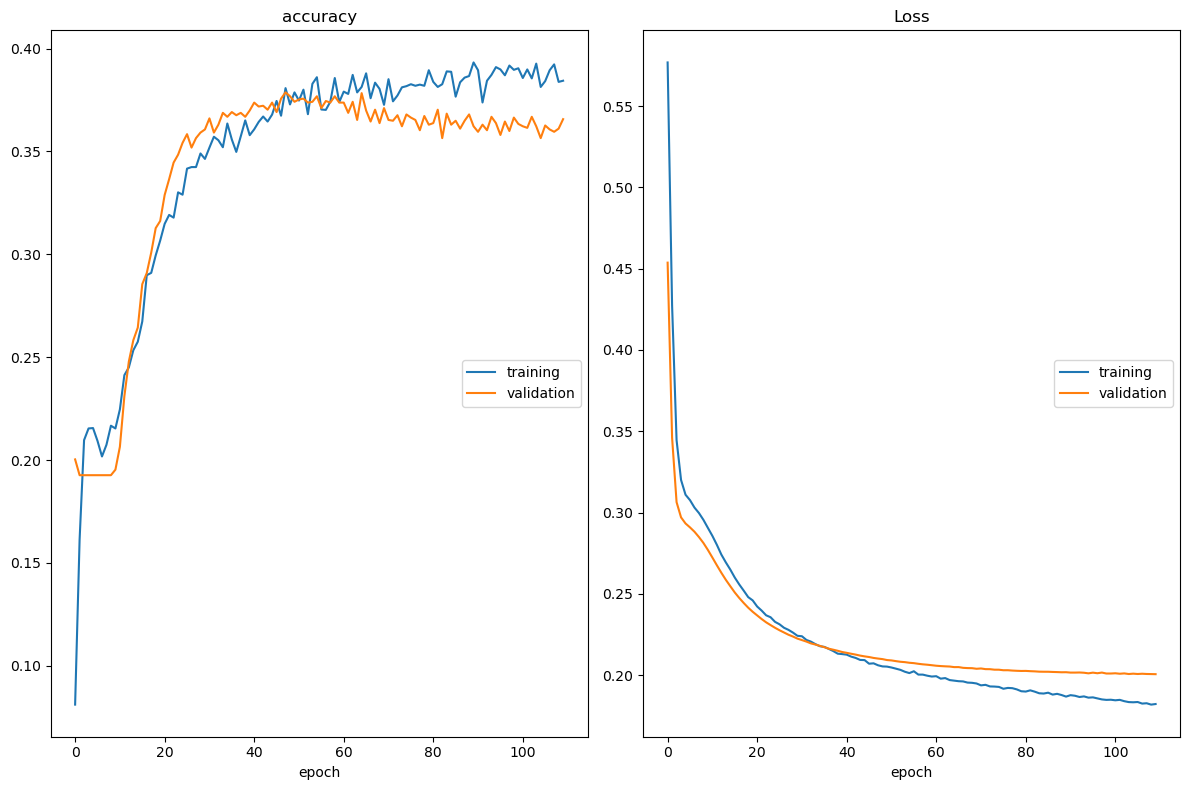

accuracy
	training         	 (min:    0.081, max:    0.393, cur:    0.384)
	validation       	 (min:    0.193, max:    0.379, cur:    0.366)
Loss
	training         	 (min:    0.182, max:    0.577, cur:    0.182)
	validation       	 (min:    0.201, max:    0.454, cur:    0.201)
8/8 [==============================] - 0s 62ms/step - loss: 0.1823 - accuracy: 0.3844 - val_loss: 0.2006 - val_accuracy: 0.3657


In [96]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_genres, validation_data=(X_test, y_test_genres),
          batch_size=680, epochs=110, verbose=1,
          callbacks=[early_stopping,PlotLossesKeras()])
model.save_weights('pesos_modelo_bert.h5')


In [100]:
y_pred_genres=model.predict(X_test)
auc_scores = roc_auc_score(y_test_genres, y_pred_genres, average=None)

AUC_TOTAL=roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print('AUC_TOTAL: ' +str(AUC_TOTAL))
# Impresión del AUC de cada clase

Para_df={}
for class_idx, auc_score in enumerate(auc_scores):
    Para_df[cols[class_idx]]=auc_score
DF_AUC_Generos = pd.DataFrame(Para_df.values(),columns=['AUC'],index=Para_df.keys())
DF_AUC_Generos=DF_AUC_Generos.sort_values(by='AUC')


y_test_genres_df = pd.DataFrame(y_test_genres,columns=cols)
y_pred_genres_df = pd.DataFrame(y_pred_genres,columns=cols)
confusion_matrices = {}

threshold = 0.5  # Umbral


for class_label in cols:
    y_true = y_test_genres_df[class_label]
    y_pred = y_pred_genres_df[class_label] 
    y_pred_binary = np.where(y_pred > threshold, 1, 0)

    cm = confusion_matrix(y_true, y_pred_binary)
    confusion_matrices[class_label] = cm
DF_AUC_Generos['Matriz Conf.'] = [confusion_matrices.get(genre) for genre in DF_AUC_Generos.index]

DF_AUC_Generos

82/82 [==============================] - 0s 2ms/step
AUC_TOTAL: 0.8756808104760768


,AUC,Matriz Conf.
p_News,0.683698,"[[2603, 0], [3, 0]]"
p_Drama,0.771944,"[[881, 442], [337, 946]]"
p_Short,0.779102,"[[2576, 0], [30, 0]]"
p_Comedy,0.816896,"[[1309, 269], [382, 646]]"
p_Romance,0.821833,"[[1824, 149], [343, 290]]"
p_Thriller,0.824443,"[[1754, 192], [330, 330]]"
p_Film-Noir,0.829902,"[[2549, 0], [57, 0]]"
p_Mystery,0.855552,"[[2334, 30], [206, 36]]"
p_Musical,0.855834,"[[2507, 2], [94, 3]]"
p_Fantasy,0.872287,"[[2329, 34], [174, 69]]"


transformación de conjunto de test

Tradicional

In [ ]:
dataTesting_min  = minusculizar(dataTesting)
dataTesting_min['plot_lematized'] = dataTesting_min['plot'].apply(lambda x: lematizar_texto(x,diccionario_original_a_lemas))
dataTesting_min.head()
xplot_vectorizer_test = vectorizer.transform(dataTesting_min['plot_lematized'])
xplot_vectorizer_test.shape

(3383, 7566)

Con modelo pre entrenado

In [62]:
dataTesting['tilte + plot'] = 'Movie titled: ' + dataTesting['title'] + ' with the following synopsis: ' +  dataTesting['plot']
sentences = dataTesting['tilte + plot'].tolist()
embeddings_titles_new = model_all_Mini.encode(sentences,show_progress_bar=True)

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

In [ ]:
new_sentences = dataTesting['plot'].tolist()

new_embeddings = model_all_Mini.encode(new_sentences)
new_embeddings

Para predecir

In [64]:
# transformación variables predictoras X del conjunto de test
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = model.predict(new_embeddings)

106/106 [==============================] - 0s 1ms/step


In [65]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RNN_sin_calibrar_PreENTR_2.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.024644,0.103931,0.002397,0.078411,0.254916,0.014029,0.000398,0.810690,0.004733,0.046537,...,0.066386,0.035629,0.001246,0.946065,0.001844,0.003041,0.000815,0.060010,0.029430,0.002140
4,0.024284,0.021768,0.000265,0.461844,0.060856,0.671529,0.068334,0.910569,0.002009,0.003101,...,0.005584,0.059903,0.002319,0.071788,0.000102,0.003049,0.002497,0.294952,0.009842,0.130533
5,0.046612,0.007399,0.000108,0.257619,0.052377,0.891229,0.038086,0.859564,0.001055,0.003642,...,0.001022,0.338317,0.001597,0.041900,0.000529,0.001249,0.002900,0.690548,0.000960,0.008081
6,0.106468,0.122479,0.001259,0.068781,0.079344,0.035141,0.004641,0.896153,0.004224,0.011375,...,0.001201,0.081259,0.001198,0.352536,0.075804,0.005244,0.000797,0.323504,0.297788,0.000193
7,0.030864,0.036076,0.007434,0.002005,0.121823,0.078812,0.003299,0.089547,0.009183,0.239476,...,0.004191,0.703739,0.000166,0.039614,0.262465,0.010864,0.000024,0.621891,0.000105,0.000060


Probar disponibilizacion

In [7]:
clasif_genre(prueba)

1/1 [==============================] - 0s 50ms/step


{'prob': {'p_Crime': 0.7309186458587646, 'p_Thriller': 0.6782251000404358}}

In [42]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
    'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
    'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

df_aux = pd.DataFrame(y_pred_plot,columns=cols).T.sort_values(by=0,ascending=False).rename(columns={0:'prob'})
genres_mas_probables = df_aux[df_aux['prob']>0.5].to_dict()

{'prob': {'p_Drama': 0.8256974220275879}}

API EN FLASK

In [3]:
# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='1.0', 
    title='Genre Clasification API',
    description='Genre Clasification  API')

ns = api.namespace('predict', 
     description='Clasificador de genros de peliculas')

# Definición argumentos o parámetros de la API
parser = api.parser()
parser.add_argument(
    'Text',
    type=str,
    required=True,
    help='Sinopsis de la película',
    location='args')


resource_fields = api.model('Resource', {
    'result': fields.String,
})

In [4]:
# Definición de la clase para disponibilización

from Api_m09_model_deployment import clasif_genre

@ns.route('/')
class PricingAPI(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        arg1 = str(args['Text'])

        return {
         "result": clasif_genre(arg1)
        }, 200

In [11]:
prueba

'a serial killer decides to teach the secrets of his satisfying career to a video store clerk .'

In [5]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.10.48:5000
Press CTRL+C to quit
127.0.0.1 - - [28/May/2023 15:45:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 15:45:01] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [28/May/2023 15:45:01] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [28/May/2023 15:45:01] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [28/May/2023 15:45:01] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [28/May/2023 15:45:01] "GET /swagger.json HTTP/1.1" 200 -


1/1 [==============================] - 0s 184ms/step


127.0.0.1 - - [28/May/2023 15:45:14] "GET /predict/?Text=a%20serial%20killer%20decides%20to%20teach%20the%20secrets%20of%20his%20satisfying%20career%20to%20a%20video%20store%20clerk%20. HTTP/1.1" 200 -
